Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

Import Dataset

In [2]:
df = pd.read_csv("Insurance claims data.csv")

Change Datatype of (max_power , max_torque)

In [3]:
df['max_torque_nm'] = df['max_torque'].str.extract(r'(\d+\.?\d*)').astype(float)
df['max_torque_rpm'] = df['max_torque'].str.extract(r'@(\d+)').astype(int)

In [4]:
df['max_power_nm'] = df['max_power'].str.extract(r'(\d+\.?\d*)').astype(float)
df['max_power_rpm'] = df['max_power'].str.extract(r'@(\d+)').astype(int)

In [5]:
df.head(10)

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,max_torque_nm,max_torque_rpm,max_power_nm,max_power_rpm
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,No,Yes,Yes,3,0,250.0,2750,113.45,4000
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,Yes,Yes,Yes,Yes,4,0,200.0,1750,97.89,3600
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,No,Yes,Yes,3,0,250.0,2750,113.45,4000
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,0,0,60.0,3500,40.36,6000
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,No,Yes,Yes,5,0,200.0,3000,88.77,4000
5,POL053680,3.1,2.0,36,C7,6112,B2,M7,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,0,0,113.0,4400,88.50,6000
6,POL053943,4.5,2.4,38,C2,27003,C2,M4,Diesel,250Nm@2750rpm,...,Yes,No,Yes,Yes,3,0,250.0,2750,113.45,4000
7,POL002857,10.7,2.0,56,C2,27003,B2,M6,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,2,0,113.0,4400,88.50,6000
8,POL028225,10.7,0.6,55,C5,34738,B1,M8,CNG,82.1Nm@3400rpm,...,No,No,Yes,Yes,2,0,82.1,3400,55.92,5300
9,POL047631,0.3,2.4,45,C3,4076,B2,M6,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,2,0,113.0,4400,88.50,6000


In [6]:
df.to_csv('new_dataset.csv',index=False)

Preprocessing

In [7]:
catg_cols = list(df.select_dtypes(include='object').drop(columns=['policy_id','max_torque','max_power']))
catg_cols

['region_code',
 'segment',
 'model',
 'fuel_type',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [8]:
binary_cat_cols = [
 'is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer',
 'is_rear_window_defogger','is_brake_assist','is_power_door_locks',
 'is_central_locking','is_power_steering','is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror','is_ecw','is_speed_alert',
 'is_esc','is_adjustable_steering','is_tpms','is_parking_sensors',
 'is_parking_camera','rear_brakes_type','transmission_type'
]

In [9]:
onehot_cols = ['segment','steering_type','fuel_type']
target_encode_cols = ['region_code','model','engine_type']

In [10]:
num_cols = list(df.select_dtypes(include='number').drop(columns=['claim_status']))
num_cols

['subscription_length',
 'vehicle_age',
 'customer_age',
 'region_density',
 'airbags',
 'displacement',
 'cylinder',
 'turning_radius',
 'length',
 'width',
 'gross_weight',
 'ncap_rating',
 'max_torque_nm',
 'max_torque_rpm',
 'max_power_nm',
 'max_power_rpm']

Handle outliers

In [11]:
# ['vehicle_age', 'customer_age','region_density'] -> has outliers

In [12]:
# handle outliers
Q1 = df[['vehicle_age', 'customer_age','region_density']].quantile(0.25)
Q3 = df[['vehicle_age', 'customer_age','region_density']].quantile(0.75)
IQR = Q3-Q1

lower_bound  = Q1 - (1.5 *IQR)
upper_bound  = Q3 + (1.5 *IQR)

df[['vehicle_age', 'customer_age','region_density']] = df[['vehicle_age', 'customer_age','region_density']].clip(lower=lower_bound, upper=upper_bound, axis=1)

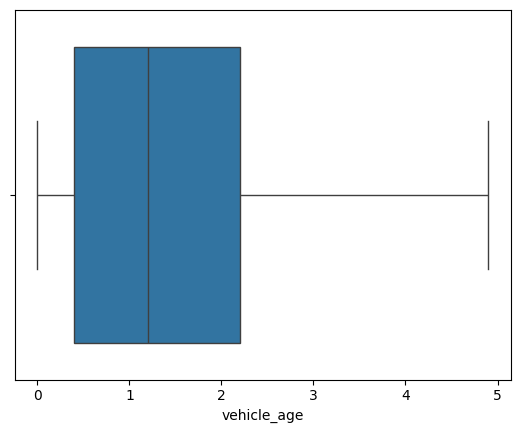

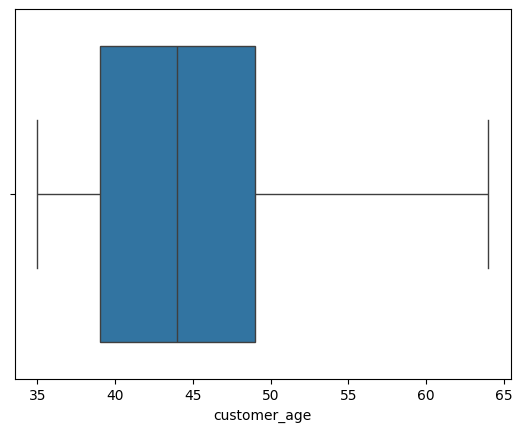

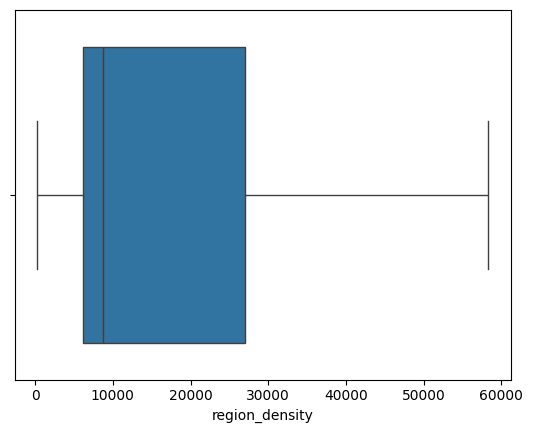

In [13]:
# check after handle
for col in ['vehicle_age', 'customer_age','region_density']:
    sns.boxplot(df,x=col)
    plt.show()

Make Pipelines

In [14]:
num_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
])

In [15]:
binary_transformer  = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OrdinalEncoder())
])

In [16]:
onehot_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

In [17]:
target_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',ce.TargetEncoder())
])

In [18]:
# Combine all
preprocessor = ColumnTransformer([
    ('num',num_transformer,num_cols),
    ('binary',binary_transformer,binary_cat_cols),
    ('onehot',onehot_transformer,onehot_cols),
    ('target',target_transformer,target_encode_cols)
])

In [19]:
# save pipeline
import joblib
joblib.dump(preprocessor, "insurance_preprocessor.pkl")

['insurance_preprocessor.pkl']